 # Tutorial for Classification of Canine Ages based on Tooth Images

To be read in association with Tutorial for Classification of Canine Ages based on Tooth Images by Oasis Husband.

 This guide will be accessible for those in vetrenary fields with low coding knowledge. Its goal is to demistify the coding aspect of artificial intelligence from those who have not seen it before.

 Image processing steps will be explained through text. Python explanations will be explained in comments. Unimportant code will be hidden by default.

Run every code block at once by clicking Runtime -> Run All. You can also run each code block one-by-one as you go, however, one function at the end of Step 5 can take up to 10 minutes.

 Tip: You can hover over most names within the code and either learn more about them, or see what information a variable is holding.

In [ ]:
# This is a comment.
hover_over_me = 10

### **Vocabulary:**
- Image: A 3-dimensional matrix of values. Width, height, and color.
- Image processing: The structure of processing an image. This can be done in many different ways. Changing the color of an image is a kind of image processing.
- Image classification: Determining a visual fact about an image.
- Dataset: A list of information.
- Image augmentation: Changing around an image. Flipping an image is image augmentation.
- Seed: a random number that the layer will use. By inputting a seed, we can ensure our results will be consistent. This is easier for explainations, but is not technically neccesary.
- Slice: One slice contains all the information for one instance of data. Each slice is like a plate of information.
- Transfer Learning: Taking the intelligence from one AI and using it as a base to build another.
- Epoch: A single iteration of training.

## Step 0: Import Libraries
A python library is a list of pre-written functions.

In [ ]:
# Graphing
# (Libraries used for showing graphs or images)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# Tensorflow
# (Libraries that use deep learning)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNet

# Other
import os
import cv2
import numpy as np
import pandas as pd

## Step 1: Gather Data

The Department of Vet Pathology has released a dataset of canine teeth sets to the general public.

The GitHub link can be found here: https://github.com/department-of-vet-pathology-unizg/dog_age

### Images

In [ ]:
# Copys the entire GitHub repository
!git clone https://github.com/department-of-vet-pathology-unizg/dog_age.git

fatal: destination path 'dog_age' already exists and is not an empty directory.


In [ ]:
# Gets a path to the images
image_path = '/content/dog_age/data/imgs'

image_names = os.listdir(image_path) # Gets a list of all of the names of images
image_names.sort() # Sorts the list in numerical order (0000, 0001, 0002...)

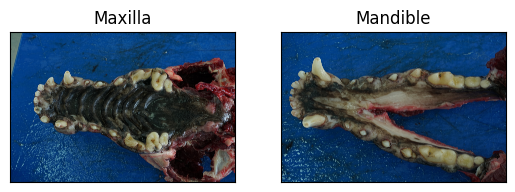

In [ ]:
# @title Display Images
maxillary = mpimg.imread(image_path+'/0000_0.jpg') # Gets the pixel matrix from this path
mandible = mpimg.imread(image_path+'/0000_1.jpg') # Gets the pixel matrix from this path

# Displays images side by side
plt.subplot(1, 2, 1) # This image will be on the left
plt.imshow(maxillary)
plt.xticks([]) # Hides x ticks
plt.yticks([]) # Hides y ticks
plt.title("Maxilla")

plt.subplot(1, 2, 2) #This image will be on the right
plt.imshow(mandible)
plt.xticks([]) # Hides x ticks
plt.yticks([]) # Hides y ticks
plt.title("Mandible")

plt.show() # Show both images

### Ages

In [ ]:
#Gets a path to the age information
age_data_path = '/content/dog_age/data/Data.csv'

#Reads the CSV file from this path
ages = pd.read_csv(age_data_path)

# Reformats the information into a list
ages = ages.loc[:, 'Age'].tolist()

# 18, in this instance. Includes 0.
ages_max = max(ages)+1

These ages are in the same order as the images, so we do not need to include any additional labels.

In [ ]:
# Show list
print(ages)

[14, 12, 4, 13, 11, 8, 3, 4, 1, 10, 13, 2, 3, 4, 4, 15, 10, 9, 1, 10, 10, 11, 0, 5, 9, 12, 11, 5, 14, 10, 2, 13, 14, 8, 7, 15, 11, 9, 9, 18, 7, 12, 14, 1]


What should be noted, if you look at the database closely, we are missing a few ages. Particularly, 6, 16, and 17.

In [ ]:
set(ages)

{0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18}

We will see later that these ages will never be guessed, because the program will have no reference point to go off of.

## Step 2: Image Pre-Processing

Pre-processing is the most important step of any image classification algorithm. We will be taking the images we've gathered in **Step 1** and making them readable to the program.

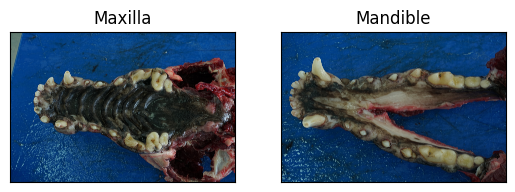

In [ ]:
# @title Display Images
maxillary = mpimg.imread(image_path+'/0000_0.jpg') # Gets the pixel matrix from this path
mandible = mpimg.imread(image_path+'/0000_1.jpg') # Gets the pixel matrix from this path

# Displays images side by side
plt.subplot(1, 2, 1) # This image will be on the left
plt.imshow(maxillary)
plt.xticks([]) # Hides x ticks
plt.yticks([]) # Hides y ticks
plt.title("Maxilla")

plt.subplot(1, 2, 2) #This image will be on the right
plt.imshow(mandible)
plt.xticks([]) # Hides x ticks
plt.yticks([]) # Hides y ticks
plt.title("Mandible")

plt.show() # Show both images

This is the form the images take. The image processer will look at the pixels of images and determine the age of the canine.

This dog is 14 years old.

In [ ]:
maxillary.shape

(4000, 6000, 3)

These images are both 4000x6000x3, which is 24 million data points. We can greatly simplify this, and still retain the neccesary information.

In [ ]:
image_size_2d = (300, 300)
image_size_3d = (300, 300, 3)
# (Different programs requre different numbers of dimensions)

We shove these images together and simplify them to a 300x300x3 matrix.

In [ ]:
# @title Combine Image Function
def combine_images(image1, image2):
  # Gets dimensions of the images
  height1, width1, _ = image1.shape
  height2, width2, _ = image2.shape

  # Determines the size of the new image
  new_width = width1 + width2
  new_height = max(height1, height2)

  # Creates a new image with white background
  new_image = np.ones((new_height, new_width, 3), dtype=np.uint8)

  # Pastes the first image on the left
  new_image[:height1, :width1, :] = image1

  # Pastes the second image on the right
  new_image[:height2, width1:, :] = image2

  return new_image

In [ ]:
# THIS CODE BLOCK TAKES APPROX. 30-60 SECONDS

images = [] # Create an empty list

# Gets file names of current and next image and iterates through them.
for tooth_0File, tooth_1File in zip(image_names, image_names[1:]):

  tooth_0Path = os.path.join(image_path, tooth_0File) # Gets path to current image
  tooth_1Path = os.path.join(image_path, tooth_1File) # Gets path to next image

  # Checks if they're the from the same set
  if tooth_0File[0:4] == tooth_1File[0:4]:

    tooth_0 = cv2.imread(tooth_0Path) # Gets the pixel matrix from this path
    tooth_1 = cv2.imread(tooth_1Path) # Gets the pixel matrix from this path

    # Shoves images together into newImage
    newImage = combine_images(tooth_0, tooth_1)

    # Resizes newImage to (300x300x3)
    newImage = cv2.resize(newImage, dsize=image_size_2d)

    # Adds image to list
    images.append(newImage)

Notice below that there is still plenty of information. You can still understand the image, though it is much more pixelated and flat.

Also note, that every image this program sees will be processed in this way. So the variableness that might confuse a person (e.g. tall canines, short molars), is perfectly normal to the program.

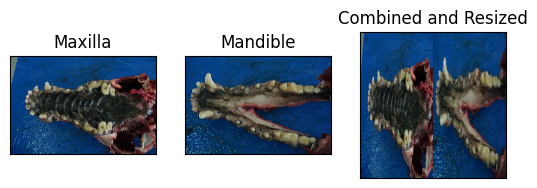

In [ ]:
# @title Display Images
# Displays images side by side
plt.subplot(1, 3, 1) # This image will be on the left
plt.imshow(maxillary)
plt.xticks([]) # Hides x ticks
plt.yticks([]) # Hides y ticks
plt.title("Maxilla")

plt.subplot(1, 3, 2) #This image will be in the middle
plt.imshow(mandible)
plt.xticks([]) # Hides x ticks
plt.yticks([]) # Hides y ticks
plt.title("Mandible")

plt.subplot(1, 3, 3) #This image will be on the right
show_image = cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB) # Recolors image to make it display correctly
plt.imshow(show_image)
plt.xticks([]) # Hides x ticks
plt.yticks([]) # Hides y ticks
plt.title("Combined and Resized")

plt.show() # Show both images

## Step 3: Database Pre-Processing

Similarly to how we needed to get the image into a form that would work for the program, we need to get the list of images suited as well.

Right now, we do not have very many images to work off of.

In [ ]:
len(images)

44

Only 44. One person can not learn from only 44 different image examples, so neither can an artificial intelligence.

Having a lower set of images is common for the medical field, because a person needs to collect and annotate the data, and then someone else needs to confirm their findings. It is difficult and slow to do, so we will have to make up for that on our side.

We can trick the program into having more information, by copying the image multiple times and performing image augmentation.

### Copying

In [ ]:
# Repeats images 4 times in this format: (1, 2, 3, 4) -> (1, 1, 1, 1, 2, 2, 2, 2...)
images_long = np.repeat(images, 4, axis=0)

# Puts the images into list format
images_long = list(images_long)

Because we are expanding the list of images, we need to expand the list of ages as well.

In [ ]:
# Repeats ages 4 times in this format: (1, 2, 3, 4) -> (1, 1, 1, 1, 2, 2, 2, 2...)
ages_long = np.repeat(ages, 4)

### Image Augmentation

We will be doing image augmentation by using layers.

In [ ]:
layers.Layer()

A learning algorithm is just a series of layers that the information runs through.

Some layers are like a water filtration system, removing unnecesary or bad data.

Some layers are scanners, learning something from the information.

Some layers are shakers, moving and changing the information slightly. These are what we will implement now.

In [ ]:
augmentationLayers = Sequential (
  [
    layers.RandomFlip("vertical", seed=3141), # Flips image
    layers.RandomContrast(0.2, seed=3141), # Lowers or brightens constrast
    layers.RandomRotation(0.001, seed=3141), # Rotates the image very slightly
    layers.RandomZoom(0.1, 0.01, 'nearest', seed=3141) # Zooms in slightly
  ]
)

Now we can drop the images through our tube of layers. Because we put each layer in a Sequential function, we can run each of them at once.

In [ ]:
images_augmented = augmentationLayers(images_long)

Now if you look below, each image is very slightly different.

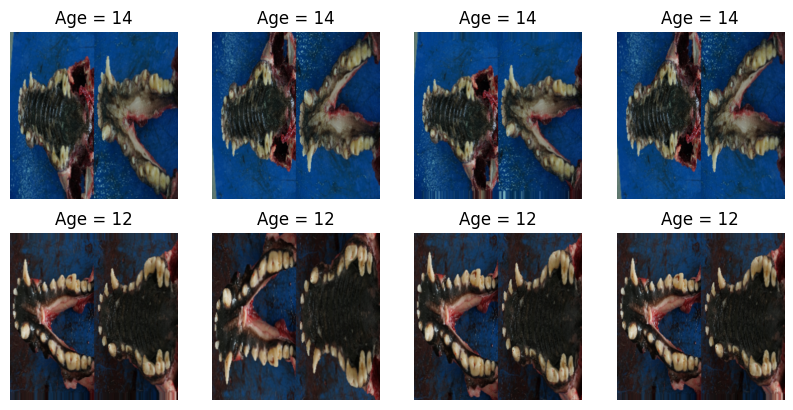

In [ ]:
# @title Display Images
# Initalizes the figure, and the size the final result will be.
plt.figure(figsize=(10, 10))

for i in range(8): # Going to show 8 images
  ax = plt.subplot(4, 4, i + 1) # The images are in an 4x2 format
  # Reverses the colors so the images look correct
  show_image = cv2.cvtColor(images_augmented[i].numpy().astype("uint8"), cv2.COLOR_BGR2RGB)
  plt.imshow(show_image) # Shows image
  plt.axis("off") # Removes numbers and tags
  ax.set_title(f"Age = {ages_long[i]}") # Titles the image with the age of the teeth featured

Even slightly changing the pixels of an image can make it seem completely new to a learning program. Look at the two lists below:

In [ ]:
print("List 1:", [7, 4, 9, 2], "\nList 2:", [8, 1, 3, 6])

List 1: [7, 4, 9, 2] 
List 2: [8, 1, 3, 6]


If looking very closely, a person might notice that the first two digits of List 2 are the same of the last two digits of List 1. But a computer isn't going to make that observation. Every number is different, therefore it is a new list.

## Step 4: Combine and Split Data

It is almost time to feed the data to an actual image processing algorithm. There are just two more issues to solve.

The program we will be using cannot take in the images and ages separately.

In [ ]:
# Takes the images and ages and combines them into dataset
dataset = tf.data.Dataset.from_tensor_slices((images_augmented, ages_long))

From now on, the images and their ages will be formatted into singular slices of data. Each slice will contain both the teeth, and their age.

We will also split the program into a training set and a test set. Essentially, we are taking some of the dataset and putting it aside, so we can check if the program actually worked.

This will be random, so the program gets a full range of images.

In [ ]:
train, test = tf.keras.utils.split_dataset(
  dataset,
  left_size = 0.90, # Percentage of training set (90%)
  shuffle = True, # Randomizes the split
  seed = 3141
)

In [ ]:
print("Number of training slices: ", len(train), "\nNumber of test slices:", len(test))

Number of training slices:  158 
Number of test slices: 18


As you can see, we've gone from only having 44 values total, we can now train the algorithm on more than three times that, while still having some left over to test the program.

## Step 5: Build the Model

It is now time to build our program. We will use transfer learning, where we essentially take a model that has already been built, and modify it slightly so it works for our data.

Let's look at the model.



In [ ]:
tf.keras.applications.MobileNet().summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32

There are many layers, but because we are using transfer learning, we only need to know about a few.

**InputLayer**'s whole job is to take the database in. It is expecting size (224, 224, 3), but will work with any size.

(Scroll all the way to the end of the code block.)

**GlobalAveragePooling2D** takes every value from an image and dumps it all into a "pool," which is a single value. This keeps the program from overanalyzing unnecesary data, and helps it focus less on the exact location of features. The algorithmic version of "soft eyes."

**Dropout.** When we run the dataset through this model, we will actually do so multiple times, or multiple epochs. To keep the program from relying on one piece of information too much, we will discard random slices.

**Predictions.** This model takes whatever input it was given, and provides a guess on what it thinks it is. We will be doing this ourselves.

From GlobalAveragePooling2D and on, we will remove their layers and build our own. Essentially, we want to use the intelligence that this model already has, and use it to determine new information. Hence, transfer learning.

In [ ]:
base_model = MobileNet(
    weights = 'imagenet',
    include_top = False, # Automatically throws away the last few layers
    input_shape = image_size_3d # Allows a different size for an input.
    #In this case: (300,  300, 3).
    )

**ImageNet** is a giant image database that many pre-trained models trained with.

**Weights** are just the name for the slight adjustments it knows to make to more accurately make predictions.

We will set the layers in the base_model to not be trainable. This is because it would be inneficient to re-train it. It has already learned all it can. We are just using that learning to help guide the new layers.

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

Now, we will construct our model.

In [ ]:
model = Sequential(
    [
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5), # Dropping out 50% of the dataset per epoch
        layers.Dense(256, activation='relu'), # 256 determines how complex
        #the model is (how many different parts of the image is it focusing on?)

        layers.Dense(ages_max, activation='softmax')
    ]
)

**Dense** layers are just fully connected to the previous layer.

**ReLu** stands for Recitified Linear Unit, which essentially stops the program from continuing down a path where it make an incorrect guess.

**SoftMax** translates output data into probabilities. This is the last layer, so it needs to be in somewhat of a readable format.



In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

**Adam** is just the name of an optimization algorithm that is commonly used.
**Sparse_categorical_crossentropy** simply means that our data is in number form (1, 2, 3...) instead of ([1 0 0], [0 1 0], [0 0 1]).

Now to fit the data. This is where we will run the dataset through, multiple times, until we find the "best fitting" results.

**Batch** just runs the data through in chunks to make it go faster and use up less memory.
**Verbose** means it will tell us more information.

As the code below runs, notice that the loss slowly gets smaller, as the accuracy slowly gets bigger.

In [ ]:
# THIS CODE BLOCK TAKES APPROX. 4 TO 7 MINUTES
model.fit(train.batch(8), epochs=20, verbose=2)

Epoch 1/20
20/20 - 13s - loss: 3.6007 - accuracy: 0.0886 - 13s/epoch - 637ms/step
Epoch 2/20
20/20 - 11s - loss: 2.8226 - accuracy: 0.1139 - 11s/epoch - 536ms/step
Epoch 3/20
20/20 - 10s - loss: 2.4864 - accuracy: 0.2215 - 10s/epoch - 484ms/step
Epoch 4/20
20/20 - 11s - loss: 2.1962 - accuracy: 0.2215 - 11s/epoch - 525ms/step
Epoch 5/20
20/20 - 11s - loss: 2.0263 - accuracy: 0.3228 - 11s/epoch - 566ms/step
Epoch 6/20
20/20 - 11s - loss: 1.7350 - accuracy: 0.4684 - 11s/epoch - 530ms/step
Epoch 7/20
20/20 - 11s - loss: 1.6289 - accuracy: 0.5063 - 11s/epoch - 555ms/step
Epoch 8/20
20/20 - 10s - loss: 1.5167 - accuracy: 0.5000 - 10s/epoch - 518ms/step
Epoch 9/20
20/20 - 11s - loss: 1.3299 - accuracy: 0.5633 - 11s/epoch - 566ms/step
Epoch 10/20
20/20 - 10s - loss: 1.2376 - accuracy: 0.5696 - 10s/epoch - 481ms/step
Epoch 11/20
20/20 - 10s - loss: 0.9240 - accuracy: 0.7152 - 10s/epoch - 522ms/step
Epoch 12/20
20/20 - 11s - loss: 0.8768 - accuracy: 0.7089 - 11s/epoch - 563ms/step
Epoch 13/20
2

## Step 6: Determine Results

This is the easiest part. All we have to do now is run the now-trained model on a test dataset.

In [ ]:
predictions = model.predict(test.batch(8))

3/3 [==============================] - 2s 330ms/step


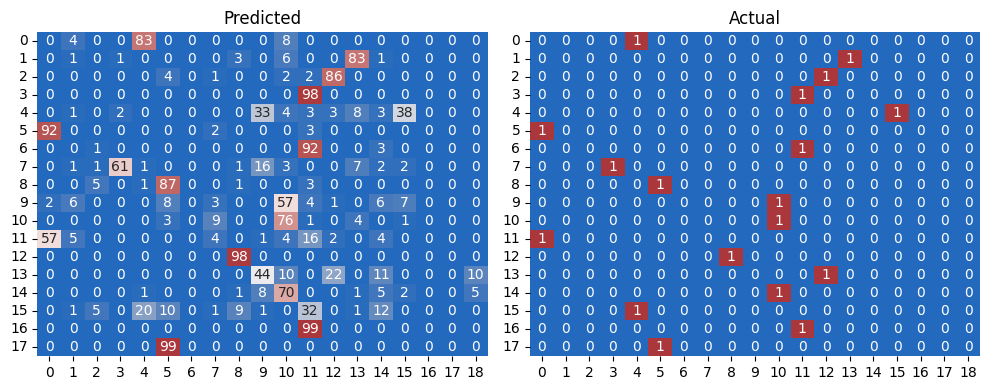

In [ ]:
# @title Show Results


# Gets predictions as percentages
predicted = predictions*100
predicted = predicted.astype(int)

# Gets actual results as a binary
actual = []

# Creates an array with 0s and set the value at the specified position to 1
for _, labels in test:
    result_array = [0] * ages_max
    result_array[labels.numpy()] = 1
    actual.append(result_array)

actual = np.array(actual) # Turns matrix into a form sns will accept

# Plots both matrices next to each other

# Create a 1x2 grid for subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot the first heatmap
sns.heatmap(predicted, cmap="vlag", annot=True, ax=axes[0], cbar=None,
            xticklabels=range(ages_max), yticklabels=range(len(predictions)))
axes[0].set_title('Predicted')

# Plot the second heatmap
sns.heatmap(actual, cmap="vlag", annot=True, ax=axes[1], cbar=None,
            xticklabels=range(ages_max), yticklabels=range(len(predictions)))
axes[1].set_title('Actual')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Gets the level of accuracy by comparing the predicted values to the actual values
top = 0
for i in range(len(predictions)):
  if np.argmax(predicted[i]) == np.argmax(actual[i]):
    top = top + 1

print("The accuracy percentage is:", round((top/(i+1))*100, 2), "%")

The accuracy percentage is: 88.89 %


As you can see, the algorithm performed fairly well. In some places, such as tests 0-4, the algorithm was fully confident. In others, especially 13 and 15, it was less so.

Note: This text might not be accurate if you have played around with seed numbers beforehand.

## Conclusion

In conclusion, this educational paper has provided a comprehensive overview of the process involved in creating and implementing a Convolutional Neural Network (CNN) for the purpose of age classification in dental images. The goal was to provide a step-by-step introduction to the coding aspect of image processing to someone in the veterinary field.

For a more in-depth, less code-focused overview of each step, please check out TEMPTEMPTEMP paper by Oasis Husband.